In [1]:
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load('mnist', split='train', shuffle_files=False)
assert isinstance(ds, tf.data.Dataset)
print(ds)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [6]:
train_images = []
train_labels = []
for example in ds:
  train_images.append(example["image"])
  train_labels.append(example["label"])

In [7]:
X = numpy.array(train_images)
y = numpy.array(train_labels)

In [8]:
X = X.reshape(X.shape[0],784)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [11]:
def divide_data(X, y , class_y):
    dataset = [X[i] for i in range(len(X)) if y[i] == class_y ]
    return numpy.array(dataset)

def mean_likelihood(X):
    return numpy.mean(X, axis=0)

def sigma_likelihood(X, mu):
    temp = numpy.zeros((X.shape[1],X.shape[1]))
    mu = mu.reshape(len(mu),1)
    for x in X:
        x = x.reshape(len(x),1)
        temp += numpy.matmul(x - mu, (x- mu).T)
    return temp/X.shape[0]

def log_density_func(x, mu, sigma):
    x = x.reshape(len(x), 1)
    mu = mu.reshape(len(mu), 1)
    '''
        expression
        removing constant terms which is same in all class conditional densities
        -(392)* numpy.log(2*numpy.pi)
    '''
    return -0.5*numpy.log(numpy.linalg.det(sigma)) - 0.5* (numpy.matmul((x - mu).T, numpy.matmul(numpy.linalg.inv(sigma), x - mu)))

'''
    Classification Bayesian
    1. Calculate posterior probabilities
    2. Get argmax over the obtained probabilities
'''
def classification_bayesian(test_image, mu_all, sig_all, prior_all):
    output_label = numpy.zeros((10,))
    for i in range(10):
        output_label[i] = prior_all[i] * log_density_func(test_image, mu_all[i], sig_all[i])
    return numpy.argmax(output_label, axis=0)


In [12]:
class_all = []

class_all.append(divide_data(X, y, 0)) 
class_all.append(divide_data(X, y, 1))
class_all.append(divide_data(X, y, 2))
class_all.append(divide_data(X, y, 3))
class_all.append(divide_data(X, y, 4))
class_all.append(divide_data(X, y, 5))
class_all.append(divide_data(X, y, 6))
class_all.append(divide_data(X, y, 7))
class_all.append(divide_data(X, y, 8))
class_all.append(divide_data(X, y, 9))

prior_all = numpy.zeros((10,1))

prior_all[0] = len(class_all[0])/len(X)
prior_all[1] = len(class_all[1])/len(X)
prior_all[2] = len(class_all[2])/len(X)
prior_all[3] = len(class_all[3])/len(X)
prior_all[4] = len(class_all[4])/len(X)
prior_all[5] = len(class_all[5])/len(X)
prior_all[6] = len(class_all[6])/len(X)
prior_all[7] = len(class_all[7])/len(X)
prior_all[8] = len(class_all[8])/len(X)
prior_all[9] = len(class_all[9])/len(X)


In [14]:
mu_all = numpy.zeros((10, 784))
sig_all = numpy.zeros((10, 784, 784))

for i in range(10):
    print("Modeling Densities for class ", i)
    # Likelihood paramters
    mu_all[i] = mean_likelihood(class_all[i])
    sig_all[i] = sigma_likelihood(class_all[i], mu_all[i])
    sig_all[i] = sig_all[i] + (numpy.diag(numpy.ones(784))*0.4)
    print("Determinant value", numpy.linalg.det(sig_all[i]))
    print("Inverse Determinant value", numpy.linalg.det(numpy.linalg.inv(sig_all[i])))


Modeling Densities for class  0
Determinant value 3.9265764470093107e-194
Inverse Determinant value 2.546747818349913e+193
Modeling Densities for class  1
Determinant value 7.045281655758364e-252
Inverse Determinant value 1.4193896693719122e+251
Modeling Densities for class  2
Determinant value 2.6135692285868164e-118
Inverse Determinant value 3.826185237651411e+117
Modeling Densities for class  3
Determinant value 9.961171674577824e-157
Inverse Determinant value 1.0038979676982723e+156
Modeling Densities for class  4
Determinant value 1.7986744600731812e-183
Inverse Determinant value 5.559649743174281e+182
Modeling Densities for class  5
Determinant value 4.692976179550155e-162
Inverse Determinant value 2.1308439713748023e+161
Modeling Densities for class  6
Determinant value 7.992006072515584e-154
Inverse Determinant value 1.2512503005211867e+153
Modeling Densities for class  7
Determinant value 1.783762343562487e-146
Inverse Determinant value 5.606127989015922e+145
Modeling Densitie

Plot Mean Images

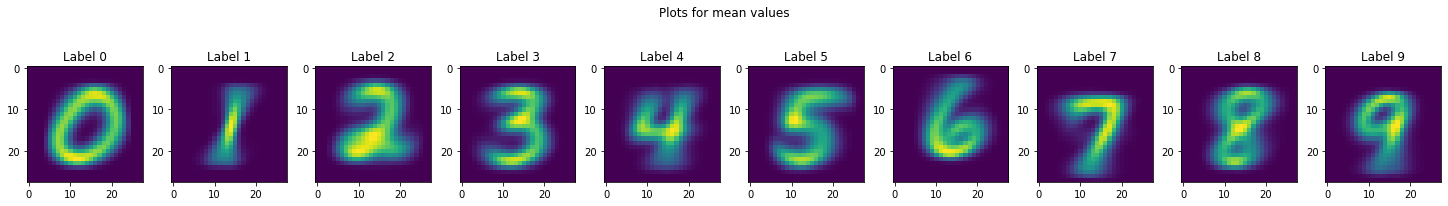

In [15]:
fig,axs = plt.subplots(1,10, figsize=(20,3), constrained_layout=True)
mu_images = scaler.inverse_transform(mu_all).reshape(10, 28, 28)
fig.suptitle("Plots for mean values")

for i in range(10):
  axs[i].imshow(mu_images[i])
  axs[i].set_title("Label " + str(i))
plt.show()

In [17]:
ds_test = tfds.load('mnist', split='test', shuffle_files=False)
assert isinstance(ds_test, tf.data.Dataset)
print(ds_test)

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [18]:
test_images = []
test_labels = []
for example in ds_test:
  test_images.append(example["image"])
  test_labels.append(example["label"])

In [19]:
X_test = numpy.array(test_images)
y_test = numpy.array(test_labels)
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000,))

In [20]:
X_test = X_test.reshape(X_test.shape[0],-1)
X_test.shape

(10000, 784)

In [22]:
from tqdm import tqdm

'''
    Accuracy on test data
'''
predicted_labels = numpy.zeros((X_test.shape[0],1))
for i in tqdm(range(len(X_test))):
    if i % 100 == 0:
        print("Tested on ", i)
    predicted_labels[i] = classification_bayesian(X_test[i], mu_all, sig_all, prior_all)



  0%|          | 0/10000 [00:00<?, ?it/s]

Tested on  0


  1%|          | 100/10000 [01:06<1:44:33,  1.58it/s]

Tested on  100


  2%|▏         | 200/10000 [02:10<1:41:55,  1.60it/s]

Tested on  200


  3%|▎         | 300/10000 [03:14<1:42:44,  1.57it/s]

Tested on  300


  4%|▍         | 400/10000 [04:19<1:40:35,  1.59it/s]

Tested on  400


  5%|▌         | 500/10000 [05:24<1:42:50,  1.54it/s]

Tested on  500


  6%|▌         | 600/10000 [06:31<1:48:49,  1.44it/s]

Tested on  600


  7%|▋         | 700/10000 [07:38<1:44:50,  1.48it/s]

Tested on  700


  8%|▊         | 800/10000 [08:43<1:45:23,  1.45it/s]

Tested on  800


  9%|▉         | 900/10000 [09:49<1:35:37,  1.59it/s]

Tested on  900


 10%|█         | 1000/10000 [10:55<1:46:48,  1.40it/s]

Tested on  1000


 11%|█         | 1100/10000 [12:01<1:35:27,  1.55it/s]

Tested on  1100


 12%|█▏        | 1200/10000 [13:06<1:36:09,  1.53it/s]

Tested on  1200


 13%|█▎        | 1300/10000 [14:11<1:38:02,  1.48it/s]

Tested on  1300


 14%|█▍        | 1400/10000 [15:18<1:32:10,  1.56it/s]

Tested on  1400


 15%|█▌        | 1500/10000 [16:26<1:39:35,  1.42it/s]

Tested on  1500


 16%|█▌        | 1600/10000 [17:36<1:36:10,  1.46it/s]

Tested on  1600


 17%|█▋        | 1700/10000 [18:45<1:32:14,  1.50it/s]

Tested on  1700


 18%|█▊        | 1800/10000 [19:50<1:27:58,  1.55it/s]

Tested on  1800


 19%|█▉        | 1900/10000 [20:56<1:28:51,  1.52it/s]

Tested on  1900


 20%|██        | 2000/10000 [22:00<1:24:48,  1.57it/s]

Tested on  2000


 21%|██        | 2100/10000 [23:08<1:33:23,  1.41it/s]

Tested on  2100


 22%|██▏       | 2200/10000 [24:15<1:22:25,  1.58it/s]

Tested on  2200


 23%|██▎       | 2300/10000 [25:19<1:20:46,  1.59it/s]

Tested on  2300


 24%|██▍       | 2400/10000 [26:23<1:23:29,  1.52it/s]

Tested on  2400


 25%|██▌       | 2500/10000 [27:29<1:25:09,  1.47it/s]

Tested on  2500


 26%|██▌       | 2600/10000 [28:35<1:25:08,  1.45it/s]

Tested on  2600


 27%|██▋       | 2700/10000 [29:41<1:17:23,  1.57it/s]

Tested on  2700


 28%|██▊       | 2800/10000 [30:47<1:18:42,  1.52it/s]

Tested on  2800


 29%|██▉       | 2900/10000 [31:53<1:16:52,  1.54it/s]

Tested on  2900


 30%|███       | 3000/10000 [33:00<1:20:30,  1.45it/s]

Tested on  3000


 31%|███       | 3100/10000 [34:09<1:24:27,  1.36it/s]

Tested on  3100


 32%|███▏      | 3200/10000 [35:18<1:15:59,  1.49it/s]

Tested on  3200


 33%|███▎      | 3300/10000 [36:26<1:11:19,  1.57it/s]

Tested on  3300


 34%|███▍      | 3400/10000 [37:30<1:10:46,  1.55it/s]

Tested on  3400


 35%|███▌      | 3500/10000 [38:37<1:12:31,  1.49it/s]

Tested on  3500


 36%|███▌      | 3600/10000 [39:42<1:06:38,  1.60it/s]

Tested on  3600


 37%|███▋      | 3700/10000 [40:46<1:05:47,  1.60it/s]

Tested on  3700


 38%|███▊      | 3800/10000 [41:54<1:08:46,  1.50it/s]

Tested on  3800


 39%|███▉      | 3900/10000 [42:59<1:08:11,  1.49it/s]

Tested on  3900


 40%|████      | 4000/10000 [44:06<1:05:23,  1.53it/s]

Tested on  4000


 41%|████      | 4100/10000 [45:11<1:08:13,  1.44it/s]

Tested on  4100


 42%|████▏     | 4200/10000 [46:16<1:07:21,  1.44it/s]

Tested on  4200


 43%|████▎     | 4300/10000 [47:23<1:03:22,  1.50it/s]

Tested on  4300


 44%|████▍     | 4400/10000 [48:29<1:01:49,  1.51it/s]

Tested on  4400


 45%|████▌     | 4500/10000 [49:33<58:22,  1.57it/s]

Tested on  4500


 46%|████▌     | 4600/10000 [50:38<59:19,  1.52it/s]

Tested on  4600


 47%|████▋     | 4700/10000 [51:43<57:26,  1.54it/s]

Tested on  4700


 48%|████▊     | 4800/10000 [52:48<55:41,  1.56it/s]

Tested on  4800


 49%|████▉     | 4900/10000 [53:52<55:50,  1.52it/s]

Tested on  4900


 50%|█████     | 5000/10000 [54:59<55:36,  1.50it/s]

Tested on  5000


 51%|█████     | 5100/10000 [56:03<53:49,  1.52it/s]

Tested on  5100


 52%|█████▏    | 5200/10000 [57:09<50:08,  1.60it/s]

Tested on  5200


 53%|█████▎    | 5300/10000 [58:14<48:31,  1.61it/s]

Tested on  5300


 54%|█████▍    | 5400/10000 [59:18<47:37,  1.61it/s]

Tested on  5400


 55%|█████▌    | 5500/10000 [1:00:21<46:53,  1.60it/s]

Tested on  5500


 56%|█████▌    | 5600/10000 [1:01:26<46:53,  1.56it/s]

Tested on  5600


 57%|█████▋    | 5700/10000 [1:02:29<44:51,  1.60it/s]

Tested on  5700


 58%|█████▊    | 5800/10000 [1:03:32<44:12,  1.58it/s]

Tested on  5800


 59%|█████▉    | 5900/10000 [1:04:35<42:51,  1.59it/s]

Tested on  5900


 60%|██████    | 6000/10000 [1:05:38<42:02,  1.59it/s]

Tested on  6000


 61%|██████    | 6100/10000 [1:06:42<40:54,  1.59it/s]

Tested on  6100


 62%|██████▏   | 6200/10000 [1:07:46<41:34,  1.52it/s]

Tested on  6200


 63%|██████▎   | 6300/10000 [1:08:49<38:13,  1.61it/s]

Tested on  6300


 64%|██████▍   | 6400/10000 [1:09:52<37:28,  1.60it/s]

Tested on  6400


 65%|██████▌   | 6500/10000 [1:10:55<35:45,  1.63it/s]

Tested on  6500


 66%|██████▌   | 6600/10000 [1:11:58<35:14,  1.61it/s]

Tested on  6600


 67%|██████▋   | 6700/10000 [1:13:02<34:37,  1.59it/s]

Tested on  6700


 68%|██████▊   | 6800/10000 [1:14:08<34:27,  1.55it/s]

Tested on  6800


 69%|██████▉   | 6900/10000 [1:15:13<35:27,  1.46it/s]

Tested on  6900


 70%|███████   | 7000/10000 [1:16:19<32:27,  1.54it/s]

Tested on  7000


 71%|███████   | 7100/10000 [1:17:23<31:20,  1.54it/s]

Tested on  7100


 72%|███████▏  | 7200/10000 [1:18:27<29:35,  1.58it/s]

Tested on  7200


 73%|███████▎  | 7300/10000 [1:19:32<28:46,  1.56it/s]

Tested on  7300


 74%|███████▍  | 7400/10000 [1:20:37<29:57,  1.45it/s]

Tested on  7400


 75%|███████▌  | 7500/10000 [1:21:43<27:40,  1.51it/s]

Tested on  7500


 76%|███████▌  | 7600/10000 [1:22:47<24:54,  1.61it/s]

Tested on  7600


 77%|███████▋  | 7700/10000 [1:23:49<23:45,  1.61it/s]

Tested on  7700


 78%|███████▊  | 7800/10000 [1:24:50<22:48,  1.61it/s]

Tested on  7800


 79%|███████▉  | 7900/10000 [1:25:52<22:27,  1.56it/s]

Tested on  7900


 80%|████████  | 8000/10000 [1:26:54<21:11,  1.57it/s]

Tested on  8000


 81%|████████  | 8100/10000 [1:27:56<19:46,  1.60it/s]

Tested on  8100


 82%|████████▏ | 8200/10000 [1:28:57<18:45,  1.60it/s]

Tested on  8200


 83%|████████▎ | 8300/10000 [1:29:59<17:55,  1.58it/s]

Tested on  8300


 84%|████████▍ | 8400/10000 [1:31:03<17:00,  1.57it/s]

Tested on  8400


 85%|████████▌ | 8500/10000 [1:32:04<15:30,  1.61it/s]

Tested on  8500


 86%|████████▌ | 8600/10000 [1:33:08<15:26,  1.51it/s]

Tested on  8600


 87%|████████▋ | 8700/10000 [1:34:10<12:58,  1.67it/s]

Tested on  8700


 88%|████████▊ | 8800/10000 [1:35:11<12:04,  1.66it/s]

Tested on  8800


 89%|████████▉ | 8900/10000 [1:36:12<11:36,  1.58it/s]

Tested on  8900


 90%|█████████ | 9000/10000 [1:37:13<10:31,  1.58it/s]

Tested on  9000


 91%|█████████ | 9100/10000 [1:38:14<09:07,  1.64it/s]

Tested on  9100


 92%|█████████▏| 9200/10000 [1:39:15<08:09,  1.64it/s]

Tested on  9200


 93%|█████████▎| 9300/10000 [1:40:16<07:04,  1.65it/s]

Tested on  9300


 94%|█████████▍| 9400/10000 [1:41:16<05:59,  1.67it/s]

Tested on  9400


 95%|█████████▌| 9500/10000 [1:42:17<05:16,  1.58it/s]

Tested on  9500


 96%|█████████▌| 9600/10000 [1:43:18<03:58,  1.68it/s]

Tested on  9600


 97%|█████████▋| 9700/10000 [1:44:17<03:01,  1.65it/s]

Tested on  9700


 98%|█████████▊| 9800/10000 [1:45:18<02:01,  1.64it/s]

Tested on  9800


 99%|█████████▉| 9900/10000 [1:46:18<00:59,  1.68it/s]

Tested on  9900


100%|██████████| 10000/10000 [1:47:19<00:00,  1.55it/s]


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix")
print(confusion)

print("Accuracy of the classification ", accuracy_score(y_test, predicted_labels))

Confusion Matrix
[[965   0   2   0   0   2   1   1   9   0]
 [  0 609  86   0  24   1   3   0 412   0]
 [  3   0 994   1   1   0   1   0  32   0]
 [  3   0   8 891   0  49   0   1  56   2]
 [  0   0   7   0 963   0   3   0   5   4]
 [  1   0   2   2   0 871   2   0  13   1]
 [  9   0   2   0   2  30 901   0  14   0]
 [  0   0  35   2  20   5   0 887  42  37]
 [  3   0   7   5   0   9   0   0 949   1]
 [  4   0  10   5  23  11   0   0  38 918]]
Accuracy of the classification  0.8948


In [26]:
!pip install scikit-plot

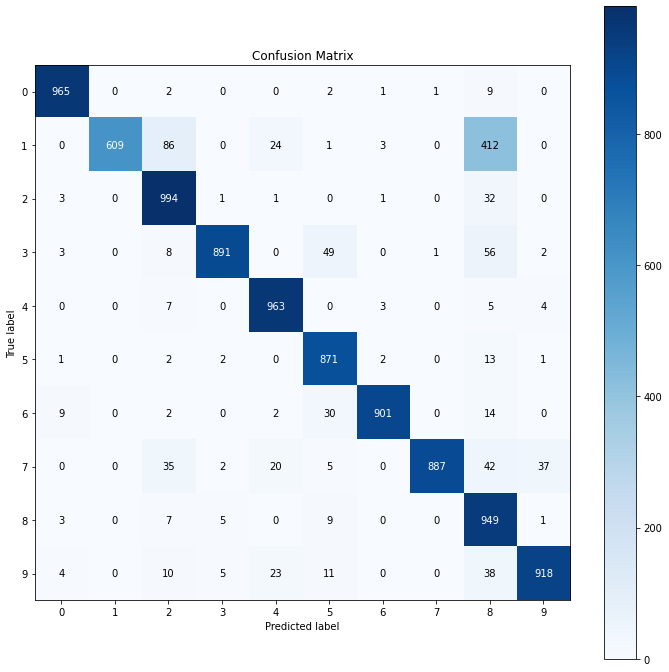

In [27]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    predicted_labels,
    figsize=(12,12))

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_labels, target_names=['0','1','2','3','4','5','6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       1.00      0.54      0.70      1135
           2       0.86      0.96      0.91      1032
           3       0.98      0.88      0.93      1010
           4       0.93      0.98      0.96       982
           5       0.89      0.98      0.93       892
           6       0.99      0.94      0.96       958
           7       1.00      0.86      0.93      1028
           8       0.60      0.97      0.75       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.89     10000
   macro avg       0.92      0.90      0.90     10000
weighted avg       0.92      0.89      0.89     10000



In [32]:
numpy.save('results_mnist_gaussian', predicted_labels)